---
# Model T - Transfer Learning, Fine-tuning, Adaptive Moment Estimation (Adam)
- **128 x 128 x 3** Image size.  
- **64** Batch size.
- **Load** our previously trained model with **Transfer Learning**, **Data Augmentation** and **Adaptive Moment Estimation (Adam)**.
- **Unfreeze the last 4 convolutional layers** of the VGG16 Convolutional Base.
- Fine-Tune the Model:
    - Adaptive Moment Estimation **(Adam)** optimizer.
    - **0.0001** Initial Learning rate.
    - **Sparse Categorical Cross-Entropy** loss function.
    - **Reduce Learning Rate on Plateau** callback with a **0.1** factor and patience of **3**.
    - **Early Stopping** callback with patience of **6** and restore best weights.
    - **Model Checkpoint** callback to save the best model based on validation loss.
    - **11 279 370** Trainable Parameters.
    - **30 Epochs** to fine-tune the model.
- **Evaluate** the model on the validation set.
- **Test** the model on the test set.

---
#### Imports and Setup

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
print(f'TensorFlow version: {tf.__version__}')
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(3)
import matplotlib.pyplot as plt
import pickle
import numpy as np
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow import keras
from tensorflow.keras import callbacks, optimizers
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay ,accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

TensorFlow version: 2.15.0


---
#### Group Datasets

In [2]:
IMG_SIZE = 128

train_dirs = [f'../data/train1_resized_{IMG_SIZE}',
              f'../data/train3_resized_{IMG_SIZE}',
              f'../data/train4_resized_{IMG_SIZE}',
              f'../data/train5_resized_{IMG_SIZE}']
validation_dir = f'../data/train2_resized_{IMG_SIZE}'
test_dir = f'../data/test_resized_{IMG_SIZE}'

---
#### Create Datasets

In [3]:
BATCH_SIZE = 64
NUM_CLASSES = 10

train_datasets = [image_dataset_from_directory(directory, image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE) for directory in train_dirs]

train_dataset = train_datasets[0]
for dataset in train_datasets[1:]:
    train_dataset = train_dataset.concatenate(dataset)

train_dataset = train_dataset.shuffle(buffer_size=1000).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset = image_dataset_from_directory(validation_dir, image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = image_dataset_from_directory(test_dir, image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

class_names = train_datasets[0].class_names

for data_batch, labels_batch in train_dataset.take(1):
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)

Found 10000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.
data batch shape: (64, 128, 128, 3)
labels batch shape: (64,)


- We define the image size of 128 x 128 x 3, batch size of 64 and create an array with the label's names.  
- We create the train dataset by concatenating them, we **shuffle** the samples before each epoch and **prefetch** them to memory.  
- We do the same for the validation and test dataset except **shuffling** which is **unwanted** for these datasets.

---
#### Loading our previously trained Model

In [4]:
model = keras.models.load_model('../models/06_model_t_tl_data_augm_adam.h5')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 tf.__operators__.getitem (  (None, 128, 128, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 128, 128, 3)       0         
 )                                                               
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0     

---
#### Previous Model Evaluation

In [5]:
val_loss, val_acc = model.evaluate(validation_dataset)
print('val_acc:', val_acc)

157/157 [==============================] - 213s 1s/step - loss: 0.4394 - accuracy: 0.9036
val_acc: 0.9035999774932861


---
#### Unfreezing the 4 last layers of the VGG16 convolutional base

In [6]:
convbase = model.get_layer("vgg16")
convbase.trainable = True
for layer in convbase.layers[:-4]:
    layer.trainable = False
for i, layer in enumerate(convbase.layers):
    print(i, layer.name, layer.trainable)

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


---
#### Model Compilation

In [7]:
initial_learning_rate = 0.0001
optimizer = optimizers.Adam(learning_rate=initial_learning_rate)
loss_function = keras.losses.SparseCategoricalCrossentropy()

lr_scheduler = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1)
save_best_model = callbacks.ModelCheckpoint(filepath='../models/07_model_t_tl_fine_tuning_adam.h5', save_best_only=True, monitor='val_loss', verbose=1)

callbacks = [lr_scheduler, early_stopping, save_best_model]

model.compile(
    loss=loss_function,
    optimizer=optimizer,
    metrics=["accuracy"])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 tf.__operators__.getitem (  (None, 128, 128, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 128, 128, 3)       0         
 )                                                               
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0     

---
#### Model Training

In [8]:
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
628/628 [==============================] - ETA: 0s - loss: 0.6073 - accuracy: 0.8438
Epoch 1: val_loss improved from inf to 0.42839, saving model to ../models/07_model_t_tl_fine_tuning_adam.h5
628/628 [==============================] - 1292s 2s/step - loss: 0.6073 - accuracy: 0.8438 - val_loss: 0.4284 - val_accuracy: 0.9014 - lr: 1.0000e-04


/usr/local/lib/python3.9/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/30
628/628 [==============================] - ETA: 0s - loss: 0.4528 - accuracy: 0.8890
Epoch 2: val_loss improved from 0.42839 to 0.37752, saving model to ../models/07_model_t_tl_fine_tuning_adam.h5
628/628 [==============================] - 1287s 2s/step - loss: 0.4528 - accuracy: 0.8890 - val_loss: 0.3775 - val_accuracy: 0.9130 - lr: 1.0000e-04
Epoch 3/30
628/628 [==============================] - ETA: 0s - loss: 0.4027 - accuracy: 0.9082
Epoch 3: val_loss improved from 0.37752 to 0.36604, saving model to ../models/07_model_t_tl_fine_tuning_adam.h5
628/628 [==============================] - 1286s 2s/step - loss: 0.4027 - accuracy: 0.9082 - val_loss: 0.3660 - val_accuracy: 0.9193 - lr: 1.0000e-04
Epoch 4/30
628/628 [==============================] - ETA: 0s - loss: 0.3500 - accuracy: 0.9208
Epoch 4: val_loss did not improve from 0.36604
628/628 [==============================] - 1287s 2s/step - loss: 0.3500 - accuracy: 0.9208 - val_loss: 0.3683 - val_accuracy: 0.9257 - lr: 1.

---
#### Save Model History

In [9]:
with open("../history/07_model_t_tl_fine_tuning_adam.pkl", "wb") as file:
    pickle.dump(history.history, file)

---
#### Model Evaluation

In [10]:
val_loss, val_acc = model.evaluate(validation_dataset)
print(f'Classifier Validation Loss: {val_loss:.2f}')
print(f'Classifier Validation Accuracy: {val_acc:.2%}')

157/157 [==============================] - 213s 1s/step - loss: 0.3073 - accuracy: 0.9442
Classifier Validation Loss: 0.31
Classifier Validation Accuracy: 94.42%


---
#### Model Visualization

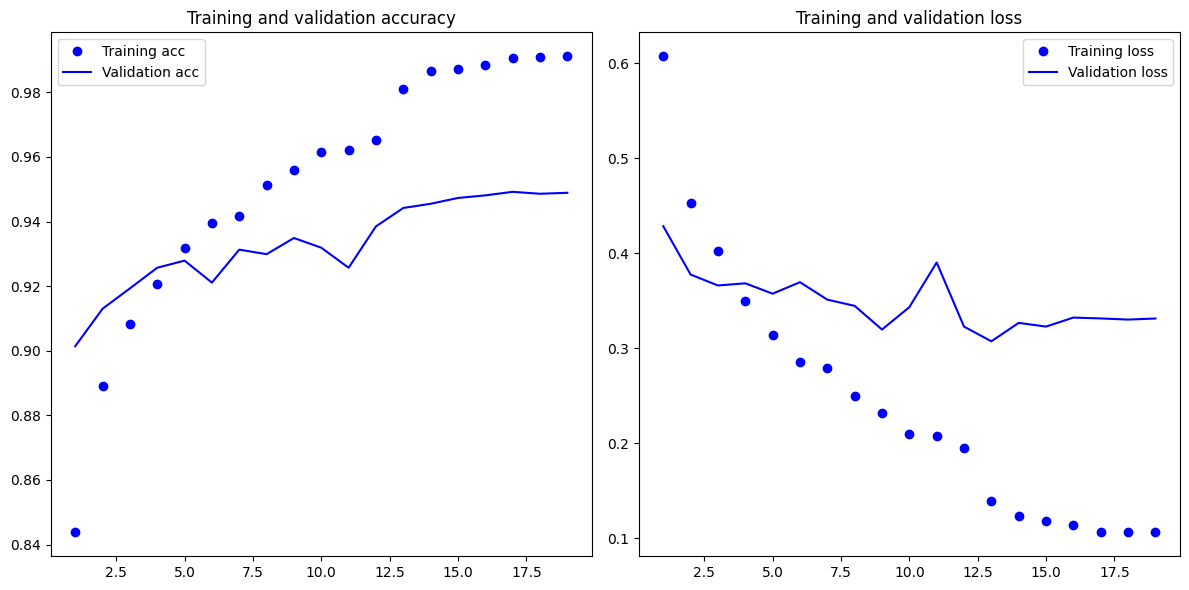

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.tight_layout()
plt.show()

- Analyzing the training and validation, accuracy and loss over the epochs:
    - We see that the model begins overfitting on the **6th** epoch.
    - The validation accuracy stops improving significantly after the **13th** epoch while the training accuracy keeps improving.
    - The validation loss stops improving significantly after the **9th** epoch while the training loss keeps improving.
    - The best model, based on validation loss, is saved on the **13th** epoch.
    - The training stops after the **19th** epoch because of the **Early Stopping** callback.

---
#### Model Testing

In [12]:
test_labels = []
test_predictions = []
test_probabilities = []

for images, labels in test_dataset:
    test_labels.extend(labels.numpy())
    predictions = model.predict(images)
    test_predictions.extend(np.argmax(predictions, axis=-1))
    test_probabilities.extend(predictions)

test_labels = np.array(test_labels)
test_predictions = np.array(test_predictions)
test_probabilities = np.array(test_probabilities)

1/1 [==============================] - 0s 413ms/step


---
#### Confusion Matrix

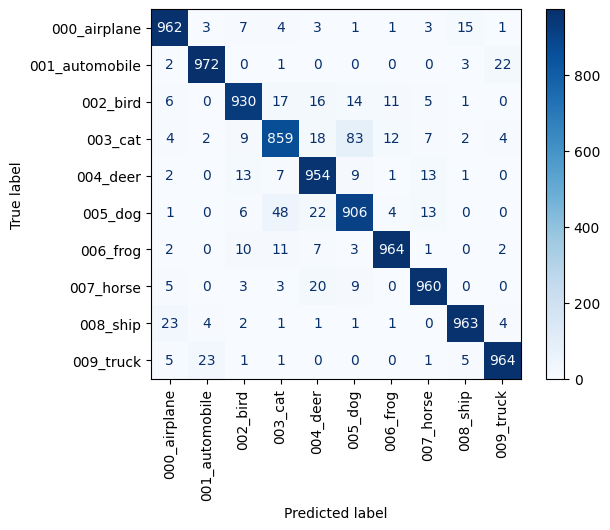

In [13]:
cm = confusion_matrix(test_labels, test_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=90)
plt.show()

- Looking at the confusion matrix, we see that:  
    - The model still has a hard time distinguishing between the categories 003_cat and 005_dog but with less error.
    - The model has a very low performance on the category 003_cat.
    - The model performs better on the vehicle categories than on the animal categories.
    - The model has a below average performance on the categories 002_bird, 003_cat and 005_dog, in which we see a very high false positive rate.
    - The model also has a hard time distinguishing between some other categories but the deviation is not as significant.  
    - The model has an above average performance on the categories 000_airplane, 001_automobile, 006_frog, 007_horse 008_ship and 009_truck.
    - **Basically, the model has the same error distribution but with higher accuracy**.

---
#### ROC Curve Analysis

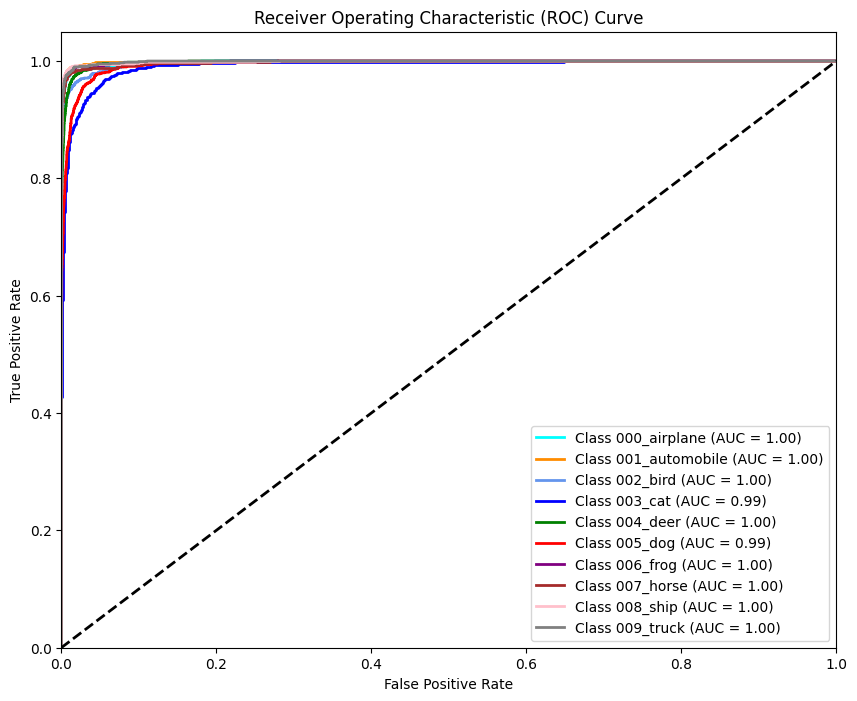

In [14]:
test_labels_bin = label_binarize(test_labels, classes=range(NUM_CLASSES))

false_positive_rate = dict()
true_positive_rate = dict()
roc_auc = dict()

for i in range(NUM_CLASSES):
    false_positive_rate[i], true_positive_rate[i], _ = roc_curve(test_labels_bin[:, i], test_probabilities[:, i])
    roc_auc[i] = auc(false_positive_rate[i], true_positive_rate[i])

plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'blue', 'green', 'red', 'purple', 'brown', 'pink', 'grey'])
for i, color in zip(range(NUM_CLASSES), colors):
    plt.plot(false_positive_rate[i], true_positive_rate[i], color=color, lw=2, label=f'Class {class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

- Looking at the ROC curve:
    - We see that the model has a good performance on the ROC curve for most categories.  
    - The categories 003_cat and 005_dog have the worst AUC (Area Under Curve) performance.
    - The other categories have the same performance but with higher AUC.
    - The overall AUC performance increases as the false positive rate decreases and the true positive rate increases.
    - **A perfect AUC of 1.0 would mean that the model classifies all images either true positives or true negatives**.

---
#### Performance Metrics
- **Accuracy** is the proportion of correctly predicted instances out of the total instances.  
- **Precision** is the ratio of true positive predictions to the total predicted positives. Macro precision calculates this for each class independently and then averages them.  
- **Weighted precision** calculates the precision for each class, then averages them, weighted by the number of true instances for each class.  
- **Recall** is the ratio of true positive predictions to the total actual positives. Macro recall calculates this for each class independently and then averages them.  
- **Weighted recall** calculates the recall for each class, then averages them, weighted by the number of true instances for each class.  
- The **F1-score** is the harmonic mean of precision and recall. Macro F1-score calculates this for each class independently and then averages them.  
- **Weighted F1-score** calculates the F1-score for each class, then averages them, weighted by the number of true instances for each class.  

In [15]:
acc = accuracy_score(y_true =  test_labels, y_pred = test_predictions)
print(f'Accuracy : {np.round(acc*100,2)}%')
precision = precision_score(y_true =  test_labels, y_pred = test_predictions, average='macro')
print(f'Precision - Macro: {np.round(precision*100,2)}%')
recall = recall_score(y_true =  test_labels, y_pred = test_predictions, average='macro')
print(f'Recall - Macro: {np.round(recall*100,2)}%')
f1 = f1_score(y_true =  test_labels, y_pred = test_predictions, average='macro')
print(f'F1-score - Macro: {np.round(f1*100,2)}%')
precision = precision_score(y_true =  test_labels, y_pred = test_predictions, average='weighted')
print(f'Precision - Weighted: {np.round(precision*100,2)}%')
recall = recall_score(y_true =  test_labels, y_pred = test_predictions, average='weighted')
print(f'Recall - Weighted: {np.round(recall*100,2)}%')
f1 = f1_score(y_true =  test_labels, y_pred = test_predictions, average='weighted')
print(f'F1-score - Weighted: {np.round(f1*100,2)}%')

Accuracy : 94.34%
Precision - Macro: 94.35%
Recall - Macro: 94.34%
F1-score - Macro: 94.33%
Precision - Weighted: 94.35%
Recall - Weighted: 94.34%
F1-score - Weighted: 94.33%


- **Since the dataset is balanced, the **MACRO** average is a good metric to evaluate the model.**

# Conclusion
### Summary
- In this notebook:
    - We loaded our previously trained model with Transfer Learning, Data Augmentation and Adaptive Moment Estimation (Adam).
    - Unfroze the last 4 convolutional layers of the VGG16 Convolutional Base.
    - We fine-tuned the model:
        - We used Adaptive Moment Estimation (Adam) optimizer.
        - Initial learning rate of 0.0001.
        - 30 Epochs with a batch size of 64, to fine-tune the model.
    - We evaluated the model on the validation dataset:
        - Overfitting was observed after **5 epochs**, but the best model was saved at the **13th epoch**.
        - Training was intended for 30 epochs but stopped early due to the **Early Stopping** callback.
    - We tested the fine-tuned model on the test set:
        - We evaluated the model using a confusion matrix to analyze its performance on each category.
        - We evaluated the model using ROC curves for a deeper performance analysis.
        - The model achieved an accuracy of 94.34% on the test set which is a good improvement.

### Future Work
- We will now implement an application to classify images using our **best model made from scratch**.